# Web Scraping Amazon.com

Used *BeautifulSoup* and *Selenium* to build an algorithm that scrapes Amazon.com and returns the **description**, **price**, **rating**, **review count** and **url** of products, based on a given search term.

---

# Import libraries

In [1]:
import csv
from bs4 import BeautifulSoup
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver

     |████████████████████████████████| 904 kB 5.2 MB/s 
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net

# Start the WebDriver

In [2]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver', options=chrome_options)
url = 'https://www.amazon.com'
wd.get(url)

# Create a function to get the page's URL

In [3]:
def get_url(search_term):
  '''Generate a url from search term'''
  template = 'https://www.amazon.com/s?k={}&ref=nb_sb_noss_1'
  search_term = search_term.replace(' ', '+')
  return template.format(search_term)

url = get_url('ultrawide monitor')
wd.get(url)
print(url)

https://www.amazon.com/s?k=ultrawide+monitor&ref=nb_sb_noss_1


# Extract the Collection and Prototype the Record

In [4]:
soup = BeautifulSoup(wd.page_source, 'html.parser')
results = soup.find_all('div', {'data-component-type': 's-search-result'})

# inspecting the results page to come up with the following:
item = results[0]
atag = item.h2.a
description = atag.text.strip()
url = 'https://amazon.com' + atag.get('href')
price_parent = item.find('span', 'a-price')
price = price_parent.find('span', 'a-offscreen').text
rating = item.i.text
review_count = item.find('span', 'a-size-base').text

# Generalize the Pattern

In [5]:
def extract_record(item):
  '''Extract and return data from a single record'''

  # description and url
  atag = item.h2.a
  description = atag.text.strip()
  url = 'https://amazon.com' + atag.get('href')
  
  try: 
    # price
    price_parent = item.find('span', 'a-price')
    price = price_parent.find('span', 'a-offscreen').text
  except AttributeError:
    return 

  try:   
    # rank and rating
    rating = item.i.text
    review_count = item.find('span', 'a-size-base').text
  except AttributeError:
    rating = ''
    review_count = ''

  result = (description, price, rating, review_count, url)

  return result

In [6]:
records = []
results = soup.find_all('div', {'data-component-type': 's-search-result'})

for item in results:
  record = extract_record(item)
  if record:
    records.append(record)

records[0]

('SAMSUNG 34-Inch SJ55W Ultrawide Gaming Monitor (LS34J550WQNXZA) – 75Hz Refresh, WQHD Computer Monitor, 3440 x 1440p Resolution, 4ms Response, FreeSync, Split Screen, HDMI, Black',
 '$351.11',
 '4.5 out of 5 stars',
 '891',
 'https://amazon.com/Samsung-S34J55W-34-Inch-Ultrawide-LS34J550WQNXZA/dp/B07FBS36W2/ref=sr_1_1?dchild=1&keywords=ultrawide+monitor&qid=1629799834&sr=8-1')

In [7]:
# testing for the prices:
for row in records:
  print(row[1])

$351.11
$246.99
$414.75
$349.99
$281.60
$279.00
$496.99
$399.99
$699.99
$149.99
$419.99
$997.83
$1,177.43
$522.11
$549.99
$1,296.99


# Getting the next page

In [8]:
def get_url(search_term):
  '''Generate a url from search term'''
  template = 'https://www.amazon.com/s?k={}&ref=nb_sb_noss_1'
  search_term = search_term.replace(' ', '+')

  # add term query to url
  url = template.format(search_term)

  # add page query placeholder
  url += '&page{}'

  return url 

# Putting it all together

In [9]:
def get_url(search_term):
  '''Generate a url from search term'''
  template = 'https://www.amazon.com/s?k={}&ref=nb_sb_noss_1'
  search_term = search_term.replace(' ', '+')

  # add term query to url
  url = template.format(search_term)

  # add page query placeholder
  url += '&page={}'

  return url

def extract_record(item):
  '''Extract and return data from a single record'''

  # description and url
  atag = item.h2.a
  description = atag.text.strip()
  url = 'https://amazon.com' + atag.get('href')
  
  try: 
    # price
    price_parent = item.find('span', 'a-price')
    price = price_parent.find('span', 'a-offscreen').text
  except AttributeError:
    return 

  try:   
    # rank and rating
    rating = item.i.text
    review_count = item.find('span', 'a-size-base').text
  except AttributeError:
    rating = ''
    review_count = ''

  result = (description, price, rating, review_count, url)

  return result

def main(search_term):
  '''Run main program routine'''
  # start up the webdriver
  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')
  wd = webdriver.Chrome('chromedriver', options=chrome_options)

  records = []
  url = get_url(search_term)

  for page in range(1, 21):
    wd.get(url.format(page))
    soup = BeautifulSoup(wd.page_source, 'html.parser')
    results = soup.find_all('div', {'data-component-type': 's-search-result'})

    for item in results:
      record = extract_record(item)
      if record:
        records.append(record)
    
  wd.close()

  # save data to csv file
  with open('results.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f, delimiter=' ')
    writer.writerow(['Description', 'Price', 'Rating', 'ReviewCount', 'Url'])
    writer.writerows(records)

# Executing and Checking the Results

In [10]:
main('ultrawide monitor')

In [11]:
import pandas as pd
results = pd.read_csv('/content/results.csv', delimiter=' ')
results.head()

,Description,Price,Rating,ReviewCount,Url
0,Sceptre 30-inch Curved Gaming Monitor 21:9 256...,$308.47,4.6 out of 5 stars,"6,797",https://amazon.com/Sceptre-30-inch-Curved-Gami...
1,"Sceptre E248W-19203R 24"" Ultra Thin 75Hz 1080p...",$141.26,4.6 out of 5 stars,"14,723",https://amazon.com/Sceptre-E248W-19203R-Monito...
2,HP 34f 34” Curved Monitor with AMD FreeSync Te...,$691.99,4.6 out of 5 stars,266,https://amazon.com/HP-34-Inch-Monitor-Freesync...
3,"Acer EI292CUR Pbmiipx 29"" 1200R 21:9 Curved Fu...",$249.99,4.4 out of 5 stars,263,https://amazon.com/Acer-EI292CUR-Pbmiipx-1200R...
4,Sceptre IPS 27-Inch Business Computer Monitor ...,$157.07,4.6 out of 5 stars,"2,329",https://amazon.com/Sceptre-Business-Computer-S...


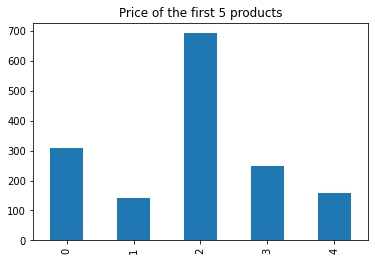

In [12]:
ax = pd.to_numeric(results.Price.str.split('$', expand=True)[1].head()).plot(kind='bar');
ax.set_xlabel('');
ax.set_title('Price of the first 5 products');

### Thank you!
If you have any suggestions and/or ideas for improvement, please, do not hesitate to leave a comment! :)